In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import time

import re
import string
import librosa
import librosa.display
import IPython.display as ipd
import torch

In [145]:
%%notify
df_train = pd.read_csv("train.csv")

<IPython.core.display.Javascript object>

In [147]:
df_train.shape

(6324, 88201)

In [3]:
df_test = pd.read_csv("test.csv")

In [4]:
df_test.shape

(999, 88201)

In [148]:
# downsample by taking every 100th entry
small = df_train[::100]
tiny = small[:1]

In [150]:
#%%notify
train = small.values#pd.read_csv("small.csv").values#

In [151]:
N_train = train.shape[0]
NUM_SAMPLES = train.shape[1]-1

print (N_train, NUM_SAMPLES)

X_train = train[:,:-1]
y_train = train[:,-1]
#y_train = y_train.reshape(N_train,1)

64 88200


In [155]:
SAMPLE_RATE = 22050

In [16]:
# JUST SOME FOURIER TRANSFORM PARAMETERS
BINS_OCTAVE = 12*2
N_OCTAVES = 7
NUM_BINS = BINS_OCTAVE * N_OCTAVES

In [17]:
# Given a wav time series, makes a mel spectrogram
# which is a short-time fourier transform with
# frequencies on the mel (log) scale.
def mel_spec(y):
    Q = librosa.cqt(y=y, sr=SAMPLE_RATE, bins_per_octave=BINS_OCTAVE,n_bins=NUM_BINS)
    Q_db = librosa.amplitude_to_db(Q,ref=np.max)
    return Q_db

In [19]:
spec = mel_spec(X_train[0])

/Users/kevinlee/anaconda/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [20]:
FEATS, FRAMES = spec.shape

In [21]:
tmp_train = np.zeros((N_train,FEATS,FRAMES))
for i in range(N_train):
    tmp_train[i,:,:] = mel_spec(X_train[i])

/Users/kevinlee/anaconda/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


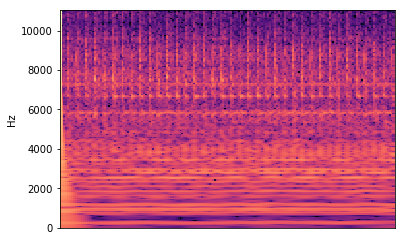

In [23]:
librosa.display.specshow(tmp_train[1], y_axis='hz')

In [24]:
ipd.Audio(X_train[1], rate=SAMPLE_RATE)

Ideas:
* make a function called "extract_features"
* Mel-frequency cepstral coefficients (MFCCs) possibly useful feature: librosa.feature.mfcc, librosa.feature.chroma_stft, librosa.feature.spectral_contrast, librosa.feature.tonnetz
* convolutions with different types of filters -- try some, maybe denoise
* another approach: kernel regression with wasserstein distance between spectra?
* will probably have to do data pre-processing separately


In [156]:
flatten = lambda l: [item for sublist in l for item in sublist]

def extract_feats(ffs, Xs):
    '''
    arguments:
        ffs: a list of feature functions, functions have to return a list (sorry)
        Xs: a numpy array of the data (X only)
    returns:
        a design matrix
    '''
    design_matrix = np.array([flatten([f(x) for f in ffs]) for x in Xs])
    return design_matrix
        

In [158]:
f0 = lambda x : [np.mean(np.array(x))]

In [159]:
test = extract_feats([f0,f0], X_train[:5])

In [134]:
test

array([[ -1.82014092e-18,  -1.82014092e-18],
       [  1.04889355e-03,   1.04889355e-03],
       [  2.04495853e-03,   2.04495853e-03],
       [  3.16277768e-03,   3.16277768e-03],
       [  4.48109702e-03,   4.48109702e-03]])

In [192]:
librosa.feature.mfcc(X_train[0]).shape

(20, 173)

In [161]:
mfs = librosa.feature.mfcc(X_train[0]).T
a = np.std(mfs, axis=0)
b = np.mean(mfs,axis = 0)
print(a)
print(b)
print(a/b)
np.mean(a/b)

[ 22.90149077  20.74106384   4.15194129   1.20336837   0.99691406
   2.01994952   2.4648515    2.62545689   2.7358591    2.51142368
   2.41200243   2.14414567   1.7916545    1.55965295   1.20159444
   0.89038459   0.60051655   0.29816058   0.22529496   0.40804014]
[ -7.72972228e+02   4.78841074e+01   4.46203627e+01   4.27198764e+01
   4.12014343e+01   3.91010159e+01   3.67176536e+01   3.40757748e+01
   3.11813277e+01   2.81209052e+01   2.48825346e+01   2.15659860e+01
   1.82113725e+01   1.48406743e+01   1.15404973e+01   8.33154362e+00
   5.25950452e+00   2.36863625e+00  -3.34830550e-01  -2.80540437e+00]
[-0.02962783  0.43315131  0.09305037  0.02816882  0.0241961   0.05165977
  0.06712988  0.07704761  0.0877403   0.08930807  0.09693556  0.09942257
  0.09838108  0.10509313  0.10411981  0.1068691   0.1141774   0.12587858
 -0.67286263 -0.14544789]


0.047719555598225723

In [162]:
f1 = lambda x : np.mean(librosa.feature.mfcc(x).T, axis = 0)

In [165]:
extract_feats([f0,f1], X_train[:5]).shape

(5, 21)

In [142]:
y_train[:5]

array([[ 0.],
       [ 7.],
       [ 8.],
       [ 4.],
       [ 8.]])

In [166]:
from sklearn.model_selection import train_test_split

In [205]:
# make a quick model tester
# to a train_test_split, train, and then report train accuracy, test accuracy (perhaps with baselines)
class ModelWrapper:
    '''
    Wrapper to simplify loading for sklearn models
    '''
    def __init__(self, X, Y, model):
        self.X = X
        self.Y = Y
        self.model = model
    
    def get_model(self):
        '''
        return the model
        '''
        assert (self.model is not None)
        return self.model
    
    def train(self, X, Y):
        '''
        train on a subset of the data
        '''
        self.model = self.get_model()
        assert (self.model is not None)
        self.model.fit(X,Y)
        
    def predict(self, X_test):
        assert (self.model is not None)
        return self.model.predict(X_test)
        
    def build(self):
        '''
        build the model, report diagnostics
        '''
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y)
        print("Training model...")
        self.train(X_train, Y_train)
        print("Done training model.")
        print("-----")
        
        training_error = accuracy_score(self.predict(X_train), Y_train)
        validation_error = accuracy_score(self.predict(X_test), Y_test)
        print("Train error:", training_error)
        print("Validation error:", validation_error)   

In [168]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import grid_search
from sklearn.grid_search import ParameterGrid

/Users/kevinlee/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/kevinlee/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [203]:
X_features = extract_feats([f0,f1], X_train)

In [209]:

rf = ModelWrapper(X_features, y_train, RandomForestClassifier(n_estimators = 14))
rf.build()

Training model...
Done training model.
-----
Train error: 1.0
Validation error: 0.5


In [207]:
rf.model.score(X_features, y_train)

0.796875

In [ ]:
rf_parameters = {'n_estimators': [5, 10], 'max_features': ['sqrt', 'log2', None], 'max_depth': [4, 25, 50, None], 'class_weight': ['balanced', None]}

In [211]:
X_features.shape

(64, 21)